In [7]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.utils_candidate_matches import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of DLC_for_WBFM.utils.feature_detection.feature_pipeline failed: Traceback (most recent call last):
  File "C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bo

In [8]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

# Annotations in the same folder as the .btf
external_annotations = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\masks-500.pickle'
external_annotations = os.path.join(bigtiff_folder, external_annotations)

# First, only subsequent matches

In [73]:
opt = {'start_frame':50,
       'num_frames':500,
       'verbose':0,
       'num_slices':33,
       #'num_subsequent_matches':1,
       'save_candidate_matches':True,
       'add_affine_to_candidates':False,
       'add_gp_to_candidates':False,
       'external_detections':external_annotations}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
# out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches, all_conf, all_frames, candidates = out

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [47:08<00:00,  5.67s/it]


In [102]:
# Force a restart at 0; the video later will have to start at the same point
list_frames = list(all_frames.values())
offset = opt['start_frame']
reindexed_matches = {(k[0]-offset,k[1]-offset):v for k,v in all_matches.items()}
clust_df = build_tracklets_from_classes(list_frames, reindexed_matches, verbose=0)

In [103]:
suffix = 'sequential-stardist'

fname = f'clust_df_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = f'match_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(all_matches, f)
fname = f'frame_dat_{suffix}.pickle'

[frame.prep_for_pickle() for frame in all_frames.values()]
with open(fname, 'wb') as f:
    pickle.dump(all_frames, f)

## Visualize

0        66
1        60
2       500
3       257
4       256
       ... 
6499      2
6500      2
6501      2
6502      2
6503      2
Name: slice_ind, Length: 6504, dtype: int64

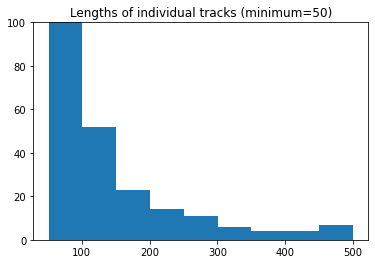

In [104]:
hist_of_tracklet_lens(clust_df)

In [79]:
k = (51,52)
plot_matched_point_clouds(all_frames, all_matches, k);

# Step 2: window consensus

In [106]:
opt = {'start_frame':50,
       'num_frames':500,
       'verbose':0,
       'num_slices':33,
       'num_subsequent_matches':7,
       'save_candidate_matches':True,
       'add_affine_to_candidates':True,
       'add_gp_to_candidates':True,
       'external_detections':external_annotations}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches, all_conf, all_frames, candidates = out

  0%|▏                                                                              | 1/500 [01:16<10:36:06, 76.49s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  0%|▎                                                                               | 2/500 [02:05<8

  4%|███▏                                                                           | 20/500 [14:35<5:28:22, 41.05s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  4%|███▎                                                                           | 21/500 [15:23<5:45:10, 43.24s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

  6%|████▉                                                                          | 31/500 [22:16<5:08:08, 39.42s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  7%|█████▏                                                                         | 33/500 [23:40<5:22:12, 41.40s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

  9%|███████▎                                                                       | 46/500 [31:44<4:36:52, 36.59s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 10%|███████▌                                                                       | 48/500 [33:09<5:01:04, 39.97s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 12%|█████████▎                                                                     | 59/500 [40:35<4:59:48, 40.79s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 14%|██████████▉                                                                    | 69/500 [48:12<5:44:41, 47.98s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

 16%|████████████▊                                                                  | 81/500 [57:31<5:00:45, 43.07s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

 20%|███████████████▏                                                             | 99/500 [1:08:55<4:10:51, 37.54s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 20%|███████████████▎                                                            | 101/500 [1:10:21<4:25:14, 39.89s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 23%|█████████████████▊                                                          | 117/500 [1:20:35<3:51:14, 36.23s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 24%|██████████████████                                                          | 119/500 [1:22:04<4:21:28, 41.18s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 27%|████████████████████▋                                                       | 136/500 [1:33:00<3:58:15, 39.27s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 28%|████████████████████▉                                                       | 138/500 [1:34:28<4

 30%|██████████████████████▋                                                     | 149/500 [1:41:14<3:25:09, 35.07s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 30%|██████████████████████▊                                                     | 150/500 [1:41:55<3:34:08, 36.71s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 33%|████████████████████████▊                                                   | 163/500 [1:50:15<3:29:06, 37.23s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 33%|████████████████████████▉                                                   | 164/500 [1:50:53<3:29:36, 37.43s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 36%|███████████████████████████▎                                                | 180/500 [2:01:32<3:50:15, 43.17s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 36%|███████████████████████████▋                                                | 182/500 [2:03:00<3

 40%|██████████████████████████████                                              | 198/500 [2:13:43<3:15:00, 38.74s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 40%|██████████████████████████████▍                                             | 200/500 [2:14:52<3:03:53, 36.78s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 43%|████████████████████████████████▊                                           | 216/500 [2:25:48<3:03:33, 38.78s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

 47%|███████████████████████████████████▍                                        | 233/500 [2:37:16<3:06:50, 41.99s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 47%|███████████████████████████████████▌                                        | 234/500 [2:37:51<2:56:54, 39.91s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the

 51%|██████████████████████████████████████▉                                     | 256/500 [2:52:45<2:39:21, 39.19s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 51%|███████████████████████████████████████                                     | 257/500 [2:53:24<2

 54%|████████████████████████████████████████▉                                   | 269/500 [3:01:18<2:27:54, 38.42s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 54%|█████████████████████████████████████████                                   | 270/500 [3:01:50<2

 57%|███████████████████████████████████████████                                 | 283/500 [3:10:33<2:33:43, 42.51s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 59%|████████████████████████████████████████████▉                               | 296/500 [3:19:15<2:23:57, 42.34s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 59%|█████████████████████████████████████████████▏                              | 297/500 [3:19:56<2

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 62%|██████████████████████████████████████████████▊                             | 308/500 [3:27:06<2:01:33, 37.99s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 65%|█████████████████████████████████████████████████▍                          | 325/500 [3:38:31<2:04:57, 42.84s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

 67%|███████████████████████████████████████████████████                         | 336/500 [3:45:55<1:52:02, 40.99s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 67%|███████████████████████████████████████████████████▏                        | 337/500 [3:46:36<1

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 70%|█████████████████████████████████████████████████████▌                      | 352/500 [3:56:08<1:33:29, 37.90s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 73%|███████████████████████████████████████████████████████▏                    | 363/500 [4:02:56<1:21:04, 35.51s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 73%|███████████████████████████████████████████████████████▎                    | 364/500 [4:03:34<1

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 75%|█████████████████████████████████████████████████████████▏                  | 376/500 [4:11:17<1:19:25, 38.43s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

 78%|███████████████████████████████████████████████████████████▍                | 391/500 [4:20:15<1:08:02, 37.46s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 79%|████████████████████████████████████████████████████████████▏               | 396/500 [4:23:27<1:06:22, 38.29s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [4:34:56<52:52, 37.33s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [4:37:16

 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [4:43:30<44:03, 37.23s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [4:44:47<43:23, 37.74s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [4:56:19<30:38, 36.76s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_proc

 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [5:09:30<16:57, 36.35s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [5:10:05<16:14, 36.09s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [5:20:01<06:08, 36.89s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [5:20:40

KeyError: 'centroids'

In [ ]:
all_communities = calc_neurons_using_k_cliques(candidates,
                                 k_values = [6,5,4,3],
                                 list_min_sizes = [450, 400],
                                 max_size = 500)

In [ ]:
clique_matches = community_to_matches(all_communities)
# Force a restart at 0; the video later will have to start at the same point
list_frames = list(all_frames.values())
clust_df = build_tracklets_from_classes(list_frames, dict(clique_matches), verbose=0)

In [ ]:
suffix = 'sequential-7-stardist'

fname = f'clust_df_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = f'match_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clique_matches, f)
fname = f'frame_dat_{suffix}.pickle'
[frame.prep_for_pickle() for frame in list_frames]
with open(fname, 'wb') as f:
    pickle.dump(list_frames, f)

# Compare to old method

In [34]:
opt = {'start_frame':51,
       'num_frames':3,
       'verbose':0,
       'num_slices':33,
       #'num_subsequent_matches':1,
       'save_candidate_matches':True,
       'add_affine_to_candidates':False,
       'add_gp_to_candidates':False,
       'external_detections':None}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
# out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches2, all_conf2, all_frames2, candidates2 = out

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 16.76s/it]


In [35]:
k = (51,52)
plot_matched_point_clouds(all_frames2, all_matches2, k);

## Two point clouds on top of one another

In [67]:
i = 52

# Reflect the x index
zxy = all_frames[i].vol_shape
neuron_locs = all_frames[i].neuron_locs.copy()
neuron_locs = neuron_locs[:, [0,2,1]]
# neuron_locs[:,2] = zxy[2] - neuron_locs[:,2]
pc_new = build_neuron_tree(neuron_locs, False)[1]
pc_new.paint_uniform_color([0,1,0])

pc_old = build_neuron_tree(all_frames2[i].neuron_locs, False)[1]
pc_old.paint_uniform_color([0.5,.5,0.5])

PointCloud with 143 points.

In [68]:
o3d.visualization.draw_geometries([pc_old, pc_new])

In [45]:
neuron_locs

array([369.02657219, 485.58744395, 492.09069212, 475.68562874,
       477.01346154, 571.71272115, 424.84378563, 586.24503311,
       339.58541459, 485.80743494, 403.13101904, 329.23891626,
       558.40498034, 410.16290727, 388.69257951, 389.09010459,
       366.72797527, 472.62327718, 374.51398026, 532.08779631,
       488.11659664, 358.66783831, 282.05089059, 514.98863636,
       502.27384615, 489.82801932, 444.11418048, 379.33460076,
       368.38700291, 372.87755102, 412.64166667, 384.00630631,
       540.5813282 , 399.70223979, 356.25837989, 452.47216495,
       469.0482866 , 456.11661808, 458.65347722, 394.95739015,
       436.34782609, 476.48628193, 462.16389245, 438.00242718,
       485.7029549 , 433.72076372, 442.68024691, 476.25827815,
       464.775     , 281.02160864, 517.23133236, 378.5915493 ,
       448.1641791 , 510.60475162, 331.79354839, 425.6468254 ,
       513.50639135, 479.3653484 , 459.08008214, 450.25336927,
       469.58024691, 487.53658537, 460.11977716, 496.74